In [ ]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import pandas as pd




plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


In [24]:
M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30
B = 145**4  # MeV^4
hc = 197.3269804  # MeV*fm
    
factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B

# Ratio

$$
R = \frac{p_{DM}}{p_{QM}}
$$

In [31]:

def compute_two_fluid_properties_ratio(e_quark, p_quark, R, grid_e_quark, grid_p_quark, grid_e_dm, grid_p_dm, r0=1e-6):

    # 1. Initial Conditions Calculation
    # ---------------------------------

    
    # Quark Matter ICs
    m_quark_c = (4/3) * np.pi * r0**3 * e_quark
    
    # Dark Matter ICs
    p_dm = p_quark * R
    e_dm = np.interp(p_dm, grid_p_dm, grid_e_dm)
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm
    
    x0 = [p_quark, m_quark_c, p_dm, m_dm_c]

    # 2. Define ODE (Nested to capture global EoS)
    # --------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        # Sanitize inputs
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        # Get Energy Densities
        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_dm, grid_e_dm)
        else:
            e2 = 0.0
        
        M = M1 + M2

        # Singularity check
        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        # Metric terms
        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        # Horizon check
        if term3 <= 1e-9:
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 Derivatives (Quark)
        if p1 <= 0:
            dp1dr, dM1dr = -1.0, 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 Derivatives (DM)
        if p2 <= 0:
            dp2dr, dM2dr = -1.0, 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # 3. Events 
    # ----------------------------------------------------

    # Event Quark Surface (do not stop)
    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = False 
    event_Quark_surface.direction = -1

    # Event DM Surface (do not stop)
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    # Event C: Stop Integration
    def event_Stop_Integration(r, x):
        return max(x[0], x[2])
    event_Stop_Integration.terminal = True
    event_Stop_Integration.direction = -1

    # 4. Run Solver
    # -------------
    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e12), 
        x0, 
        events=[event_Quark_surface, event_DM_surface,  event_Stop_Integration],
        rtol=1e-8, 
        atol=1e-10,
        first_step=1e-7
    )

    r_adim = sol.t.copy()
    p1_adim = sol.y[0].copy()
    m1_adim = sol.y[1].copy()
    p2_adim = sol.y[2].copy()
    m2_adim = sol.y[3].copy()

    # --- EXTRACT EXACT RADII FROM EVENTS ---
    # sol.t_events is a list containing the R values for each event function.
    # Index [0] corresponds to event_Quark_surface
    # Index [1] corresponds to event_DM_surface

    # 1. Quark Matter Handling
    if len(sol.t_events[0]) > 0:
        R_quark_final = sol.t_events[0][0] # Take the first crossing
        #print(f"Quark Surface detected at R = {R_quark_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        # This replaces the manual index search
        p1_adim[r_adim > R_quark_final] = 0.0
    else:
        R_quark_final = None
        print("Quark pressure never crossed zero (or started at 0).")

    # 2. Dark Matter Handling
    if len(sol.t_events[1]) > 0:
        R_DM_final = sol.t_events[1][0] # Take the first crossing
        #print(f"DM Surface detected at R = {R_DM_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        p2_adim[r_adim > R_DM_final] = 0.0
    else:
        R_DM_final = None
        print("DM pressure never crossed zero (or started at 0).")

    
    # Calculate Masses (these arrays always exist, so this is safe)
    M1_phys = m1_adim * factor_M_to_Solar
    M2_phys = m2_adim * factor_M_to_Solar
    M_total = M1_phys + M2_phys

    R_quark_result = R_quark_final * factor_R_to_km if R_quark_final is not None else None
    R_dm_result = R_DM_final * factor_R_to_km if R_DM_final is not None else None

    results = {
        "R_quark": R_quark_result,
        "R_dm": R_dm_result,
        "M_total": M_total[-1],
        "M_quark": M1_phys[-1],
        "M_dm": M2_phys[-1]
    }
    return results



For only EOS I: R=0

In [32]:

data = pd.read_csv('../Data/EOS_MIT_B145.csv') #adim

grid_e_quark = (data['x']) 
grid_p_quark = (data[' y']) 


central_energy_densities_phys = np.linspace(200,1e4,10000) # MeV/fm^3
central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_quark, grid_p_quark)

list_Rqm_quark = []
list_Rdm_quark = []
list_M_quark = []
list_Mqm_quark = []
list_Mdm_quark = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0, grid_e_quark=grid_e_quark, grid_p_quark=grid_p_quark, grid_e_dm=grid_e_quark, grid_p_dm=grid_p_quark)
    list_Rqm_quark.append(data['R_quark'])
    list_Rdm_quark.append(data['R_dm'])
    list_M_quark.append(data['M_total'])
    list_Mqm_quark.append(data['M_quark'])
    list_Mdm_quark.append(data['M_dm'])


data = pd.read_csv('../Data/EOSII_Mikel.csv') #Mev/fm3

# Extract columns
grid_e_2 = (10 ** data['x']) * hc **3 / (4*B) #dimensionless
grid_p_2 = (10 ** data[' y']) * hc **3 / (4*B) #dimensionless

central_energy_densities_phys = np.linspace(10,2e3,100000) # MeV/fm^3
central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) # dimensionless
central_pressures = np.interp(central_energy_densities, grid_e_2, grid_p_2) # dimensionless

grid_e_eos2 = central_energy_densities
grid_p_eos2 = central_pressures


data = pd.read_csv('../Data/EOS1_Mikel.csv') #Mev/fm3

# Extract columns
grid_e_1 = (10 ** data['x']) * hc **3 / (4*B)
grid_p_1 = (10 ** data[' y']) * hc **3 / (4*B)


central_energy_densities_phys = np.linspace(10,2e3,10000) # MeV/fm^3
central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_1, grid_p_1)

grid_e_eos1 = central_energy_densities
grid_p_eos1 = central_pressures

central_energy_densities_phys = np.linspace(10,2e3,100) # MeV/fm^3
central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_eos1, grid_p_eos1)

list_Rqm_0 = []
list_Rdm_0 = []
list_M_0 = []
list_Mqm_0 = []
list_Mdm_0 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0, grid_e_quark=grid_e_eos1, grid_p_quark=grid_p_eos1, grid_e_dm=grid_e_eos1, grid_p_dm=grid_e_eos1)
    list_Rqm_0.append(data['R_quark'])
    list_Rdm_0.append(data['R_dm'])
    list_M_0.append(data['M_total'])
    list_Mqm_0.append(data['M_quark'])
    list_Mdm_0.append(data['M_dm'])


central_pressures = np.interp(central_energy_densities, grid_e_eos2, grid_p_eos2)

list_Rqm_0_eos2 = []
list_Rdm_0_eos2 = []
list_M_0_eos2 = []
list_Mqm_0_eos2 = []
list_Mdm_0_eos2 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]

    # ... inside the loop, after defining central_pressures ...

    # 1. Create the grid for this EOS
    grid_e_current = central_energy_densities
    grid_p_current = central_pressures

    # 2. SORT by Pressure (Crucial for np.interp inside ODE)
    # We sort by P because the ODE calculates E(P)
    sort_idx = np.argsort(grid_p_current)
    grid_p_sorted = grid_p_current[sort_idx]
    grid_e_sorted = grid_e_current[sort_idx]

    # 3. Add Vacuum/Crust Point (Crucial for Surface Radius)
    # If the EOS doesn't start at P=0, E=0, force it.
    # (Unless it is strictly self-bound like MIT Bag, but usually digitized data needs this anchor)
    if grid_p_sorted[0] > 1e-9:
        grid_p_sorted = np.insert(grid_p_sorted, 0, 0.0)
        grid_e_sorted = np.insert(grid_e_sorted, 0, 0.0)

    # 4. Compute
    # Note the fix in grid_p_dm arguments as well
    data = compute_two_fluid_properties_ratio(
        e_central, 
        p_central, 
        R=0, 
        grid_e_quark=grid_e_sorted, 
        grid_p_quark=grid_p_sorted, 
        grid_e_dm=grid_e_sorted,   # Fixed
        grid_p_dm=grid_p_sorted    # Fixed (was grid_e_eos1)
    )

    list_Rqm_0_eos2.append(data['R_quark'])
    list_Rdm_0_eos2.append(data['R_dm'])
    list_M_0_eos2.append(data['M_total'])
    list_Mqm_0_eos2.append(data['M_quark'])
    list_Mdm_0_eos2.append(data['M_dm'])


Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started at 0).
Quark pressure never crossed zero (or started 

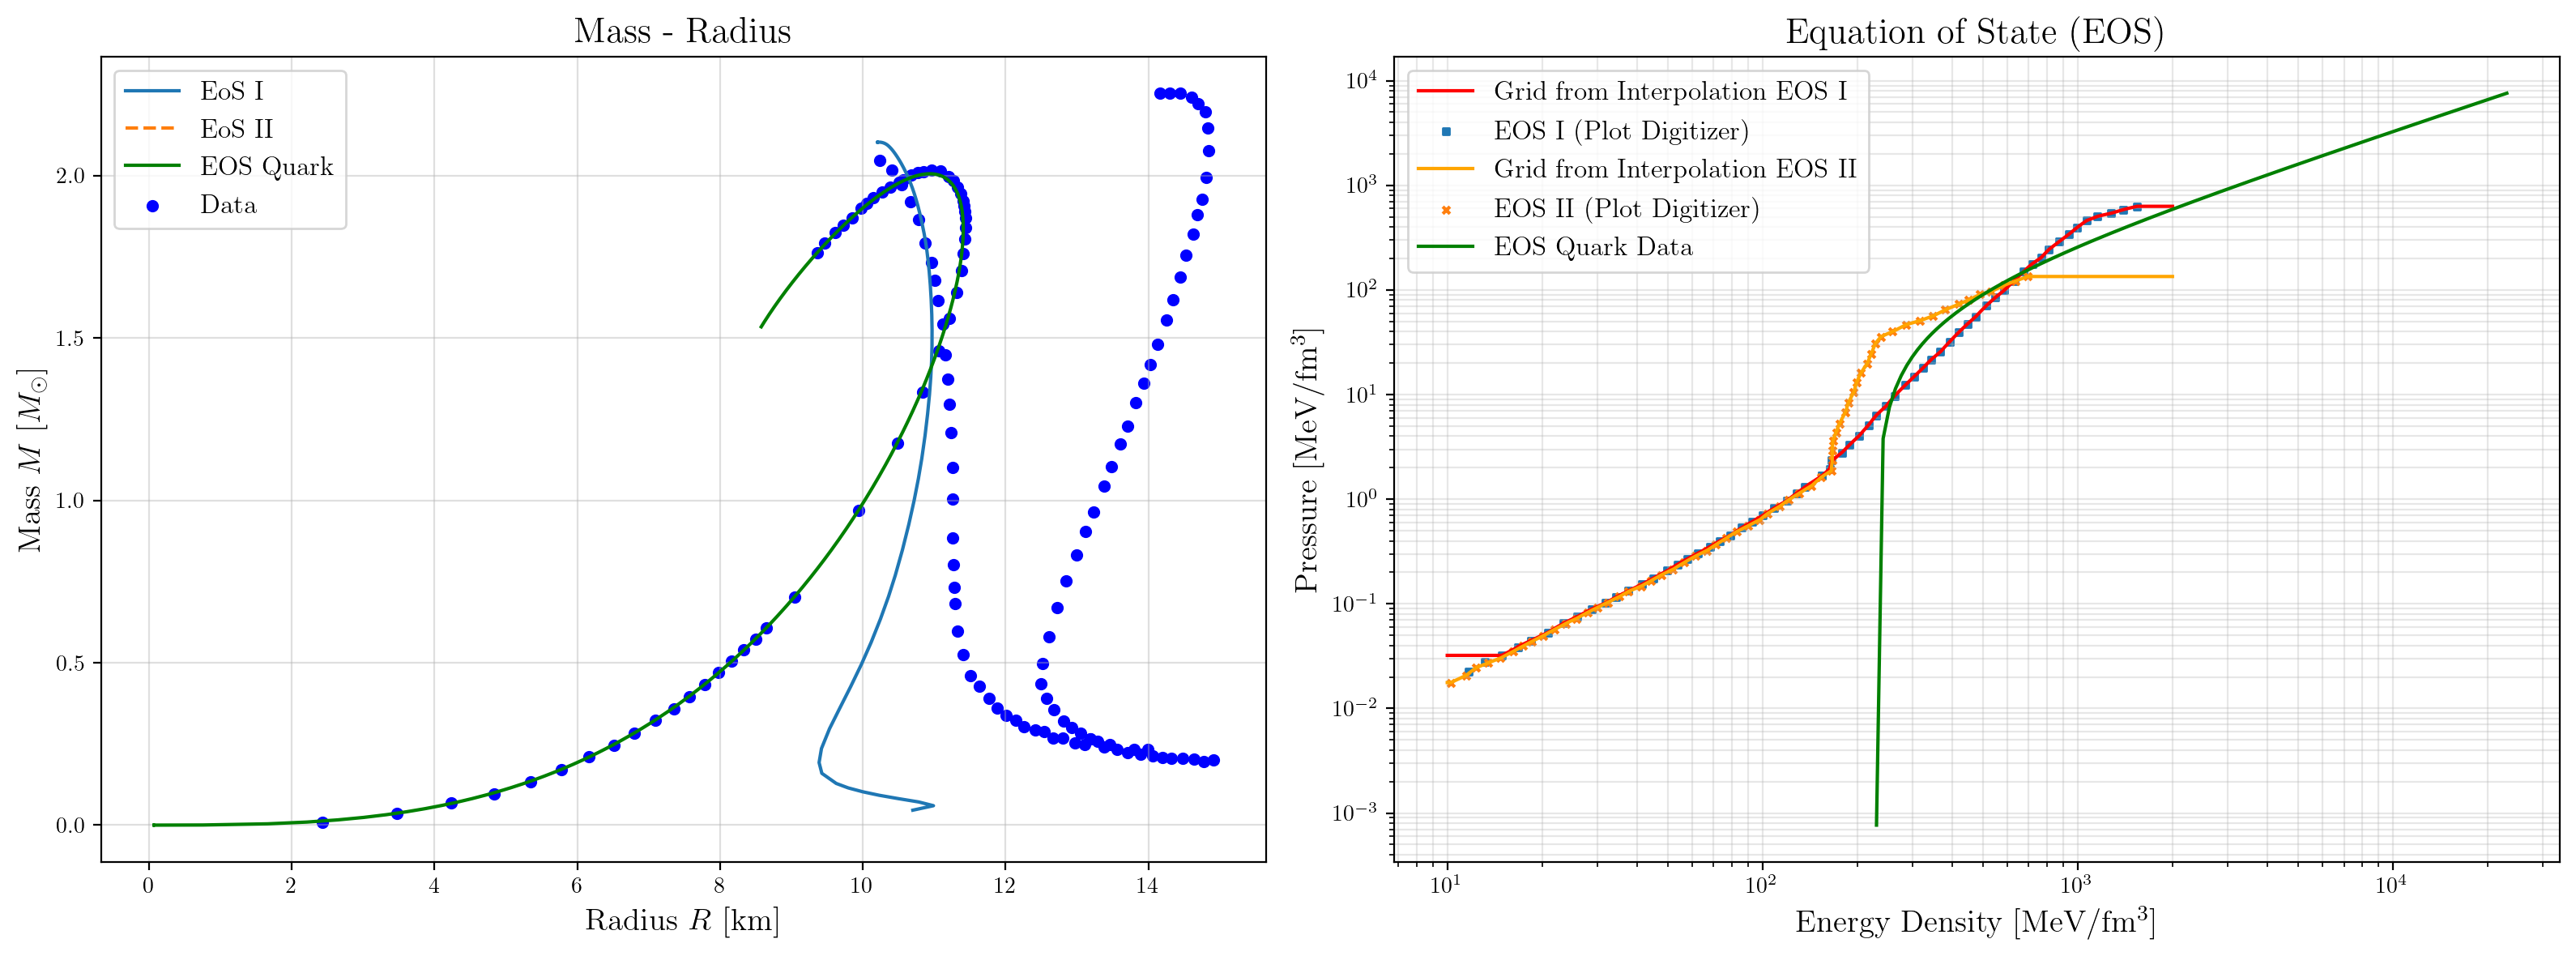

In [33]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

#open a csv file
mr = pd.read_csv('../Data/Mass_radius_EOS1andEOS2.csv')

data = pd.read_csv('../Data/Mass_Radius_145MeV.csv') #adim

axs[0].scatter(data['x'], data[' y'], color='blue', s=20,)

# --- Plot 1: Mass-Radius Diagram (Left) ---
axs[0].plot(list_Rqm_0, list_M_0, label=r'EoS I')
axs[0].plot(list_Rqm_0_eos2, list_M_0_eos2, label=r'EoS II', linestyle='--') # Added dashed line for contrast
axs[0].plot(list_Rqm_quark, list_M_quark, color='green', label='EOS Quark')


axs[0].scatter(mr['x'], mr[' y'], color='blue', s=20, label='Data')
axs[0].set_xlabel(r'Radius $R$ [km]', fontsize=14)
axs[0].set_ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[0].set_title(r' Mass - Radius', fontsize=16)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# --- Plot 2: Equation of State (Right) ---
# EOS I Data

axs[1].plot(grid_e_eos1 * (4 * B) / hc**3, grid_p_eos1 * (4 * B) / hc**3, color='red', label='Grid from Interpolation EOS I')
axs[1].scatter(grid_e_1 * (4 * B) / hc**3, grid_p_1 * (4 * B) / hc**3, label='EOS I (Plot Digitizer)', s=10, marker='s')

# EOS II Data

axs[1].plot(grid_e_eos2 * (4 * B) / hc**3, grid_p_eos2 * (4 * B) / hc**3, color='orange', label='Grid from Interpolation EOS II')
axs[1].scatter(grid_e_2* (4 * B) / hc**3, grid_p_2* (4 * B) / hc**3, label='EOS II (Plot Digitizer)', s=10, marker='x') # Changed color/marker

#EOS Quark
axs[1].plot(grid_e_quark * (4 * B) / hc**3, grid_p_quark * (4 * B) / hc**3, color='green', label='EOS Quark Data')

# EOS Plot Formatting
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel('Pressure [MeV/fm$^3$]', fontsize=14)
axs[1].set_xlabel('Energy Density [MeV/fm$^3$]', fontsize=14)
axs[1].set_title('Equation of State (EOS)', fontsize=16)
axs[1].legend(fontsize=12)
axs[1].grid(True, which="both", alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

The problem is not the interpolation.